In [ ]:
%%capture

!pip install datasets unidecode

## Finetune - French

In [ ]:
# -*- coding: utf-8 -*-
"""## Finetune - French"""

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from unidecode import unidecode
import os

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def prepare_dataset(examples):
    texts = examples['text']
    new_texts = []
    for text in texts:
        new_texts.append(text)
    return {'text': new_texts}

dataset = load_dataset('Sabrina1763/wikipedia_french', split='train[0:40000]')
dataset = dataset.map(prepare_dataset, batched=True)

def tokenize_function(examples):
    result = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

    result['labels'] = result['input_ids'].clone()

    return result

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_dataset.set_format('torch')

training_args = TrainingArguments(
    output_dir='./gpt2-french',
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=64,
    save_steps=100,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=100,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

trainer.train()
model.save_pretrained('./gpt2-french')
tokenizer.save_pretrained('./gpt2-french')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/540 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/240M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/90.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/89.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Step,Training Loss
100,3.679700
200,3.263700
300,3.108300
400,3.031700
500,2.991100
600,2.936900


('./gpt2-french/tokenizer_config.json',
 './gpt2-french/special_tokens_map.json',
 './gpt2-french/vocab.json',
 './gpt2-french/merges.txt',
 './gpt2-french/added_tokens.json')

## Load datasets

In [ ]:
"""# load datasets"""

import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
import logging
from tqdm import tqdm
import numpy as np
from scipy.interpolate import BSpline
from torch.nn.functional import kl_div, log_softmax, softmax, cosine_similarity

base_model_name = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load datasets
ds1 = load_dataset('wujohns/gpt2-base-learn', split="train[0:6000]")
ds2 = load_dataset('Sabrina1763/wikipedia_french', split='train[0:18000]')

# Create combined dataset with labels
combined_texts = []
combined_labels = []
for j in range(3):
    for i in ds1:
        combined_texts.append(i['text'])
        combined_labels.append(0)  # ds1 is better handled by base model
for i in ds2:
    combined_texts.append(i['text'])
    combined_labels.append(1)  # ds2 is better handled by fine-tuned model

print(f"Number of rows in combined_texts: {len(combined_texts)}")

dataset = Dataset.from_dict({"text": combined_texts, "label": combined_labels})

def tokenize_function(examples):
    outputs = tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    return {'input_ids': outputs['input_ids'], 'attention_mask': outputs['attention_mask'], 'label': examples['label']}

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=[])
tokenized_datasets.set_format('torch')

sample_size = min(20000, len(tokenized_datasets))
train_dataset = tokenized_datasets.shuffle(seed=42).select(range(sample_size))

val_size = int(0.1 * sample_size)
train_dataset = train_dataset.select(range(sample_size - val_size))
val_dataset = tokenized_datasets.shuffle(seed=42).select(range(sample_size - val_size, sample_size))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Number of rows in combined_texts: 36000


Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

## Architecture

In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
import logging
from tqdm import tqdm
import numpy as np
from scipy.interpolate import BSpline



torch.manual_seed(123)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model_name, fine_tuned_model_name = 'gpt2', './gpt2-french'
base_model = GPT2LMHeadModel.from_pretrained(base_model_name).to(device)
fine_tuned_model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_name).to(device)

# Set requires_grad to False for base and fine-tuned models
for model in [base_model, fine_tuned_model]:
    for param in model.parameters():
        param.requires_grad = False

num_layers = len(base_model.transformer.h)

class BSplineAlpha(nn.Module):
    def __init__(self, num_layers, num_control_points=16, degree=3):
        super().__init__()
        self.num_layers = num_layers
        self.num_control_points = num_control_points
        self.degree = degree
        # Initialized with rand-unif [0.45 - 0.55]
        self.control_points = nn.Parameter(torch.rand(num_control_points, device=device) * 0.1 + 0.45)
        # Add trainable bias term for each layer
        self.layer_biases = nn.Parameter(torch.zeros(num_layers, device=device))
        self.knot_vector = self._generate_knot_vector()
        self.register_buffer('basis_functions', self._compute_basis_functions())

    def _generate_knot_vector(self):
        num_knots = self.num_control_points + self.degree + 1
        knot_vector = np.linspace(0, 1, num_knots - 2 * self.degree)
        return np.concatenate((
            np.zeros(self.degree),
            knot_vector,
            np.ones(self.degree)
        ))

    def _compute_basis_functions(self):
        x = torch.linspace(0, 1, self.num_layers)
        basis_functions = np.zeros((self.num_layers, self.num_control_points))
        for i in range(self.num_control_points):
            coeffs = np.zeros(self.num_control_points)
            coeffs[i] = 1.0
            spline = BSpline(self.knot_vector, coeffs, self.degree)
            basis_functions[:, i] = spline(x.numpy())
        return torch.tensor(basis_functions, dtype=torch.float32, device=device)

    def forward(self):
        # Compute base alpha values from spline
        base_alpha_values = torch.matmul(self.basis_functions, self.control_points)
        # Add layer-specific biases and clamp
        alpha_values = torch.clamp(base_alpha_values + self.layer_biases * 0.1, 0.0, 1.0)
        return alpha_values



class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

class Conv1dWithPermute(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(Conv1dWithPermute, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = x.permute(0, 2, 1)
        return x

class Autoencoder(nn.Module):
    def __init__(self, hidden_size, bottleneck_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(hidden_size, bottleneck_size),
            nn.GELU()
        )

        self.decoder = nn.Sequential(
            Conv1dWithPermute(
                in_channels=bottleneck_size,
                out_channels=hidden_size,
                kernel_size=3,
                padding=1
            ),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class MergedModel(GPT2LMHeadModel):
    def __init__(self, base_model, fine_tuned_model, alpha_module, autoencoders, autoencoder_layers=[3, 4, 5, 6, 7, 8, 9, 10]):
        super().__init__(base_model.config)
        self.base_model = base_model
        self.fine_tuned_model = fine_tuned_model
        self.alpha_module = alpha_module
        self.autoencoders = autoencoders

        # Assuming both models share the same configuration
        self.config = base_model.config

        # Extract transformer blocks from both models
        self.base_blocks = base_model.transformer.h
        self.fine_tuned_blocks = fine_tuned_model.transformer.h

        # Store both base and fine-tuned embeddings
        self.base_wte = base_model.transformer.wte  # Base token embeddings
        self.base_wpe = base_model.transformer.wpe  # Base position embeddings
        self.ft_wte = fine_tuned_model.transformer.wte  # Fine-tuned token embeddings
        self.ft_wpe = fine_tuned_model.transformer.wpe  # Fine-tuned position embeddings

        self.drop = base_model.transformer.drop  # Dropout layer
        self.ln_f = base_model.transformer.ln_f  # Final layer norm

        # Language modeling head
        self.lm_head = base_model.lm_head

        self.selected_autoencoder_layers = autoencoder_layers

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, input_ids, attention_mask=None, output_hidden_states=False, return_dict=False, is_training=False):
        device = input_ids.device

        alpha_values = self.alpha_module()

        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        # Prepare attention mask
        batch_size, seq_length = input_ids.size()
        causal_mask = torch.tril(torch.ones((seq_length, seq_length), device=device)).unsqueeze(0).unsqueeze(0)
        attention_mask = attention_mask.view(batch_size, 1, 1, seq_length)
        attention_mask = attention_mask * causal_mask
        attention_mask = attention_mask.to(dtype=self.base_model.dtype)  # For fp16 compatibility
        attention_mask = (1.0 - attention_mask) * -10000.0  # Masked positions

        # Compute all embeddings at once and average
        position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        base_embeddings_state = self.base_wte(input_ids) + self.base_wpe(position_ids)
        fine_embeddings_state = self.ft_wte(input_ids) + self.ft_wpe(position_ids)

        # alpha = torch.mean(alpha_values)
        alpha = 0
        hidden_states = (1 - alpha) * base_embeddings_state + alpha * fine_embeddings_state

        hidden_states = self.drop(hidden_states)

        all_hidden_states = []
        if output_hidden_states:
            all_hidden_states = [hidden_states]

        # Sequentially pass through transformer blocks and autoencoders
        num_layers = len(self.base_blocks)

        all_blended_hidden_states = []
        for idx in range(num_layers):
            base_block = self.base_blocks[idx]
            fine_tuned_block = self.fine_tuned_blocks[idx]

            # Base and fine-tuned outputs
            base_outputs = base_block(hidden_states, attention_mask=attention_mask)
            base_hidden_states = base_outputs[0]

            fine_tuned_outputs = fine_tuned_block(hidden_states, attention_mask=attention_mask)
            fine_tuned_hidden_states = fine_tuned_outputs[0]

            # Blend hidden states
            alpha = alpha_values[idx]
            alpha = alpha.view(1, 1, -1)
            blended_hidden_state = (1 - alpha) * base_hidden_states + alpha * fine_tuned_hidden_states

            all_blended_hidden_states.append(blended_hidden_state)
            # Pass through autoencoder
            autoencoder_idx = idx  # Index matches the layer index

            # Apply autoencoder only to specified layers
            if autoencoder_idx in self.selected_autoencoder_layers:
                reconstructed_hidden_state = self.autoencoders[f"layer_{autoencoder_idx}"](blended_hidden_state)
            else:
                reconstructed_hidden_state = blended_hidden_state

            # Input for the next layer
            if is_training:
                hidden_states = blended_hidden_state
            else:
                hidden_states = reconstructed_hidden_state

            all_hidden_states.append(reconstructed_hidden_state)
        # Final layer norm
        hidden_states = self.ln_f(hidden_states)

        # Compute logits
        logits = self.lm_head(hidden_states)

        if not return_dict:
            return logits

        output = {'logits': logits}
        if output_hidden_states:
            output['hidden_states'] = all_hidden_states
            output['blended_hidden_states'] = all_blended_hidden_states
            output['alpha_values'] = alpha_values
        if return_dict:
            return output
        else:
            return logits

## Integrated Metrics

In [ ]:
"""## Training loop"""

tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

criterion_mse = nn.MSELoss()

torch.manual_seed(123)

alpha_module = BSplineAlpha(num_layers=num_layers).to(device)

autoencoder_layers = [3, 4, 5, 6, 7, 8]

hidden_size = base_model.config.n_embd
bottleneck_size = int(hidden_size * 0.75)

# Initialize autoencoders only for the specified layers
autoencoders = nn.ModuleDict({
    f"layer_{layer_idx}": Autoencoder(hidden_size, bottleneck_size).to(device)
    for layer_idx in autoencoder_layers
})

# Initialize merged model with updated autoencoders
merged_model = MergedModel(base_model, fine_tuned_model, alpha_module, autoencoders, autoencoder_layers).to(device)

# Initialize optimizer
optimizer_params = [
    {'params': alpha_module.parameters(), 'lr': 1e-4},
    {'params': autoencoders.parameters(), 'lr': 1e-4}
]
optimizer = torch.optim.AdamW(optimizer_params, weight_decay=1e-2)

## Benchmarks helpers

In [ ]:

# Initialize lists to store metrics
epochs_list = []
merged_ppl_list = []
interp_ppl_list = []
ta_ppl_list = []
merged_acc_list = []
interp_acc_list = []
ta_acc_list = []
merged_jsd_list = []
merged_cos_list = []
interp_cos_list = []
ta_cos_list = []
avg_loss_list = []
avg_lm_loss_list = []
avg_recon_loss_list = []

def calculate_perplexity(logits, labels, attention_mask):
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    shift_attention_mask = attention_mask[..., 1:].contiguous()

    loss_fct = nn.CrossEntropyLoss(reduction='none')
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    masked_loss = loss * shift_attention_mask.view(-1)
    num_tokens = torch.sum(shift_attention_mask).float()
    perplexity = torch.exp(torch.sum(masked_loss) / num_tokens)
    return perplexity

def calculate_accuracy(logits, labels, attention_mask):
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    shift_attention_mask = attention_mask[..., 1:].contiguous()

    preds = torch.argmax(shift_logits, dim=-1)
    correct_predictions = (preds == shift_labels) & (shift_attention_mask == 1)
    accuracy = correct_predictions.sum().float() / shift_attention_mask.sum()
    return accuracy

def calculate_jsd(logits1, logits2):
    """Calculates Jensen-Shannon Divergence between two logits distributions."""
    prob1 = softmax(logits1, dim=-1)
    prob2 = softmax(logits2, dim=-1)
    log_prob1 = log_softmax(logits1, dim=-1)
    log_prob2 = log_softmax(logits2, dim=-1)
    m = 0.5 * (prob1 + prob2)
    return 0.5 * (kl_div(log_prob1, m, reduction='batchmean') + kl_div(log_prob2, m, reduction='batchmean'))

def calculate_cosine_similarity(logits1, logits2):
    """Calculates the average cosine similarity between two logits distributions."""
    prob1 = softmax(logits1, dim=-1)
    prob2 = softmax(logits2, dim=-1)
    similarity = cosine_similarity(prob1, prob2, dim=-1)
    return similarity.mean()

# --- Linear Interpolation Function ---
def linear_interpolation_merge(model1, model2, alpha):
    merged_model = GPT2LMHeadModel(model1.config)
    for n, p in merged_model.named_parameters():
        if n in model1.state_dict() and n in model2.state_dict():
            p.data.copy_((1 - alpha) * model1.state_dict()[n] + alpha * model2.state_dict()[n])
    return merged_model.to(device)

# --- Task Arithmetic Function ---
def task_arithmetic_merge(base_model, finetuned_model, alpha):
    merged_model = GPT2LMHeadModel(base_model.config)
    base_params = dict(base_model.named_parameters())
    finetuned_params = dict(finetuned_model.named_parameters())
    for name, param in merged_model.named_parameters():
        if name in base_params and name in finetuned_params:
            param.data.copy_(base_params[name].data + alpha * (finetuned_params[name].data - base_params[name].data))
        elif name in base_params:
            param.data.copy_(base_params[name].data)
    return merged_model.to(device)

In [ ]:
num_epochs = 10
clip_value = 1.0

interpolation_alpha = 0.5
interpolated_model = linear_interpolation_merge(base_model, fine_tuned_model, interpolation_alpha)

task_arithmetic_alpha = 0.5
task_arithmetic_model = task_arithmetic_merge(base_model, fine_tuned_model, task_arithmetic_alpha)

for epoch in range(num_epochs):
    total_loss, total_lm_loss, total_recon_loss = 0, 0, 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # --- Merged Model Forward Pass (training mode) ---
        merged_outputs = merged_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
            is_training=True  # Training forward
        )

        merged_logits = merged_outputs['logits']
        reconstructed_hidden_states = merged_outputs['hidden_states']
        alpha_values = merged_model.alpha_module()

        # Language modeling loss for merged model
        shift_logits = merged_logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()
        lm_loss = nn.CrossEntropyLoss()(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        # Reconstruction loss for merged model
        recon_loss = 0

        with torch.no_grad():
            base_outputs = base_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True
            )
            base_logits = base_outputs.logits
            base_hidden_states = base_outputs.hidden_states

            fine_tuned_outputs = fine_tuned_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True
            )
            fine_tuned_logits = fine_tuned_outputs.logits
            fine_tuned_hidden_states = fine_tuned_outputs.hidden_states

        for idx in range(1, len(reconstructed_hidden_states)):  # Start from 1 to skip embeddings
            layer_idx = idx - 1  # Adjust for embeddings layer at idx=0
            h_recon = reconstructed_hidden_states[idx]  # idx corresponds to hidden state index
            h_base = base_hidden_states[idx].detach()
            h_finetuned = fine_tuned_hidden_states[idx].detach()
            labels_expanded = labels.view(-1, 1, 1).float()
            target_hidden_state = h_base * (1 - labels_expanded) + h_finetuned * labels_expanded
            recon_loss_layer = criterion_mse(h_recon, target_hidden_state)
            recon_loss += recon_loss_layer

        loss = recon_loss * 3.0 + lm_loss * 1.0
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoders.parameters(), clip_value)
        torch.nn.utils.clip_grad_norm_(alpha_module.parameters(), clip_value)
        optimizer.step()

        total_loss += loss.item()
        total_lm_loss += lm_loss.item()
        total_recon_loss += recon_loss.item()

        # ------------------
        # EVALUATE METRICS
        # ------------------

        #
        # --- Evaluate Merged Model (inference mode, is_training=False) ---
        #
        with torch.no_grad():
            # Second forward pass with is_training=False
            merged_outputs_eval = merged_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                return_dict=True,
                is_training=False  # Important: evaluation forward
            )
            merged_logits_eval = merged_outputs_eval['logits']

            merged_perplexity = calculate_perplexity(merged_logits_eval, input_ids, attention_mask)
            merged_accuracy = calculate_accuracy(merged_logits_eval, input_ids, attention_mask)

            # Compare merged logits to average of experts for JSD / Cos
            merged_jsd = calculate_jsd(merged_logits_eval, 0.5 * (base_logits + fine_tuned_logits))
            merged_cosine = calculate_cosine_similarity(merged_logits_eval, 0.5 * (base_logits + fine_tuned_logits))

        #
        # --- Interpolated Model Evaluation ---
        #
        with torch.no_grad():
            interpolated_outputs = interpolated_model(input_ids=input_ids, attention_mask=attention_mask)
            interpolated_logits = interpolated_outputs.logits

            # Calculate Perplexity for Interpolated Model
            interp_perplexity = calculate_perplexity(interpolated_logits, input_ids, attention_mask)

            # Calculate Accuracy for Interpolated Model
            interp_accuracy = calculate_accuracy(interpolated_logits, input_ids, attention_mask)

            # Cosine similarity
            interp_cosine = calculate_cosine_similarity(
                interpolated_logits,
                0.5 * (base_logits + fine_tuned_logits)
            )

        #
        # --- Task Arithmetic Model Evaluation ---
        #
        with torch.no_grad():
            ta_outputs = task_arithmetic_model(input_ids=input_ids, attention_mask=attention_mask)
            ta_logits = ta_outputs.logits

            # Calculate Perplexity for Task Arithmetic Model
            ta_perplexity = calculate_perplexity(ta_logits, input_ids, attention_mask)

            # Calculate Accuracy for Task Arithmetic Model
            ta_accuracy = calculate_accuracy(ta_logits, input_ids, attention_mask)

            # Cosine similarity
            ta_cosine = calculate_cosine_similarity(
                ta_logits,
                0.5 * (base_logits + fine_tuned_logits)
            )

        progress_bar.set_postfix({
            'loss': f"{loss.item():.6f}",
            'lm_loss': f"{lm_loss.item():.6f}",
            'recon_loss': f"{recon_loss.item():.6f}",
            'M-PPL': f"{merged_perplexity.item():.2f}",
            'I-PPL': f"{interp_perplexity.item():.2f}",
            'TA-PPL': f"{ta_perplexity.item():.2f}",
            'M-Acc': f"{merged_accuracy.item():.4f}",
            'I-Acc': f"{interp_accuracy.item():.4f}",
            'TA-Acc': f"{ta_accuracy.item():.4f}",
            'M-JSD': f"{merged_jsd.item():.4f}",
            'M-Cos': f"{merged_cosine.item():.4f}",
            'I-Cos': f"{interp_cosine.item():.4f}",
            'TA-Cos': f"{ta_cosine.item():.4f}",
        })

    avg_loss = total_loss / len(train_loader)
    avg_lm_loss = total_lm_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Avg Loss: {avg_loss:.6f}, Avg LM Loss: {avg_lm_loss:.6f}, Avg Recon Loss: {avg_recon_loss:.6f}")

    # Store metrics for the epoch
    epochs_list.append(epoch + 1)
    merged_ppl_list.append(merged_perplexity.item())
    interp_ppl_list.append(interp_perplexity.item())
    ta_ppl_list.append(ta_perplexity.item())
    merged_acc_list.append(merged_accuracy.item())
    interp_acc_list.append(interp_accuracy.item())
    ta_acc_list.append(ta_accuracy.item())
    merged_jsd_list.append(merged_jsd.item())
    merged_cos_list.append(merged_cosine.item())
    interp_cos_list.append(interp_cosine.item())
    ta_cos_list.append(ta_cosine.item())
    avg_loss_list.append(avg_loss)
    avg_lm_loss_list.append(avg_lm_loss)
    avg_recon_loss_list.append(avg_recon_loss)

print("\nTraining completed")

Epoch 1/10: 100%|██████████| 563/563 [07:07<00:00,  1.32it/s, loss=653.208618, lm_loss=3.579876, recon_loss=216.542908, M-PPL=100.87, I-PPL=48.53, TA-PPL=50.26, M-Acc=0.2408, I-Acc=0.3166, TA-Acc=0.3171, M-JSD=82.9164, M-Cos=0.5617, I-Cos=0.9067, TA-Cos=0.9017]


Epoch 1/10, Avg Loss: 1189.762047, Avg LM Loss: 3.641725, Avg Recon Loss: 395.373440


Epoch 2/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=612.524231, lm_loss=3.743110, recon_loss=202.927048, M-PPL=66.77, I-PPL=56.61, TA-PPL=57.32, M-Acc=0.2672, I-Acc=0.2864, TA-Acc=0.2869, M-JSD=59.5942, M-Cos=0.6226, I-Cos=0.9140, TA-Cos=0.9121]


Epoch 2/10, Avg Loss: 628.527249, Avg LM Loss: 3.611710, Avg Recon Loss: 208.305179


Epoch 3/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=612.619446, lm_loss=3.548986, recon_loss=203.023468, M-PPL=47.90, I-PPL=51.42, TA-PPL=50.75, M-Acc=0.3066, I-Acc=0.3208, TA-Acc=0.3153, M-JSD=45.5636, M-Cos=0.6906, I-Cos=0.9164, TA-Cos=0.9124]


Epoch 3/10, Avg Loss: 615.901692, Avg LM Loss: 3.587520, Avg Recon Loss: 204.104724


Epoch 4/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=608.691467, lm_loss=3.672972, recon_loss=201.672836, M-PPL=48.52, I-PPL=58.76, TA-PPL=57.93, M-Acc=0.3161, I-Acc=0.2975, TA-Acc=0.3015, M-JSD=44.1716, M-Cos=0.6974, I-Cos=0.9158, TA-Cos=0.9129]


Epoch 4/10, Avg Loss: 607.575880, Avg LM Loss: 3.568039, Avg Recon Loss: 201.335947


Epoch 5/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=622.510559, lm_loss=3.531785, recon_loss=206.326248, M-PPL=37.65, I-PPL=46.37, TA-PPL=47.19, M-Acc=0.3597, I-Acc=0.3401, TA-Acc=0.3386, M-JSD=41.0194, M-Cos=0.7113, I-Cos=0.9030, TA-Cos=0.9015]


Epoch 5/10, Avg Loss: 600.864118, Avg LM Loss: 3.552516, Avg Recon Loss: 199.103867


Epoch 6/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=582.295166, lm_loss=3.772975, recon_loss=192.840744, M-PPL=46.78, I-PPL=59.99, TA-PPL=60.12, M-Acc=0.3036, I-Acc=0.2879, TA-Acc=0.2879, M-JSD=38.7568, M-Cos=0.7124, I-Cos=0.9136, TA-Cos=0.9146]


Epoch 6/10, Avg Loss: 594.996854, Avg LM Loss: 3.540166, Avg Recon Loss: 197.152229


Epoch 7/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=594.923340, lm_loss=3.696043, recon_loss=197.075760, M-PPL=45.50, I-PPL=53.71, TA-PPL=54.32, M-Acc=0.3238, I-Acc=0.2963, TA-Acc=0.2992, M-JSD=40.6356, M-Cos=0.7058, I-Cos=0.9023, TA-Cos=0.9061]


Epoch 7/10, Avg Loss: 589.854663, Avg LM Loss: 3.530507, Avg Recon Loss: 195.441385


Epoch 8/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=556.110657, lm_loss=3.257657, recon_loss=184.284348, M-PPL=35.19, I-PPL=44.35, TA-PPL=45.33, M-Acc=0.3549, I-Acc=0.3395, TA-Acc=0.3231, M-JSD=40.1422, M-Cos=0.7353, I-Cos=0.9037, TA-Cos=0.8945]


Epoch 8/10, Avg Loss: 585.146319, Avg LM Loss: 3.522933, Avg Recon Loss: 193.874462


Epoch 9/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=594.348999, lm_loss=3.799133, recon_loss=196.849960, M-PPL=48.42, I-PPL=61.49, TA-PPL=61.21, M-Acc=0.3263, I-Acc=0.3066, TA-Acc=0.2997, M-JSD=36.4855, M-Cos=0.7313, I-Cos=0.9127, TA-Cos=0.9184]


Epoch 9/10, Avg Loss: 581.642845, Avg LM Loss: 3.518755, Avg Recon Loss: 192.708029


Epoch 10/10: 100%|██████████| 563/563 [07:06<00:00,  1.32it/s, loss=556.862488, lm_loss=3.558299, recon_loss=184.434738, M-PPL=47.02, I-PPL=60.29, TA-PPL=61.30, M-Acc=0.3270, I-Acc=0.3039, TA-Acc=0.2957, M-JSD=43.3261, M-Cos=0.7237, I-Cos=0.9041, TA-Cos=0.9092]

Epoch 10/10, Avg Loss: 579.841344, Avg LM Loss: 3.518242, Avg Recon Loss: 192.107700

Training completed


In [ ]:
merged_model.eval()

merged_model_path_to_save = './gpt2-french/merged_model.bin'
torch.save(merged_model.state_dict(), merged_model_path_to_save)
print(f"Merged model saved to {merged_model_path_to_save}")

Merged model saved to ./gpt2-french/merged_model.bin


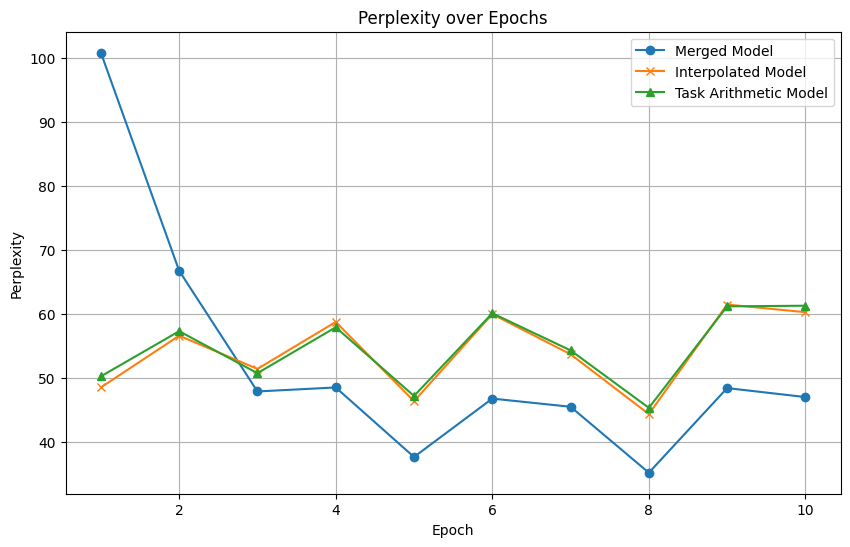

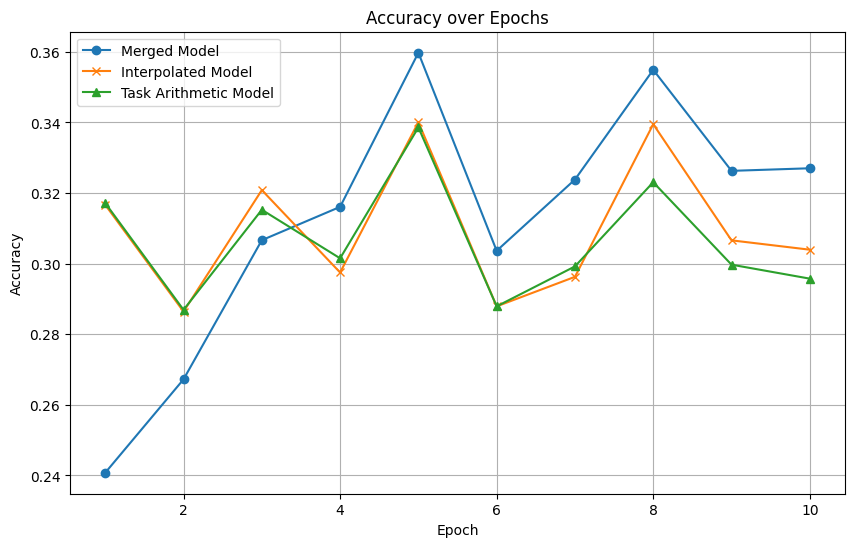

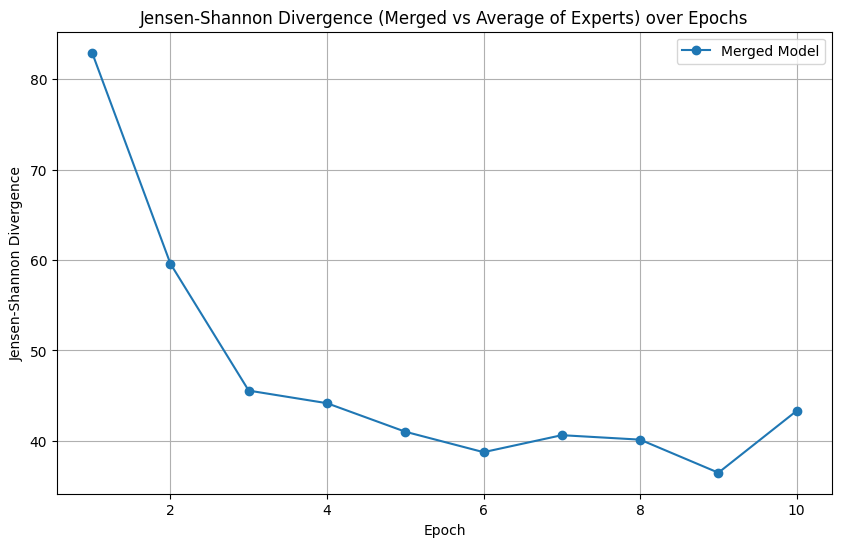

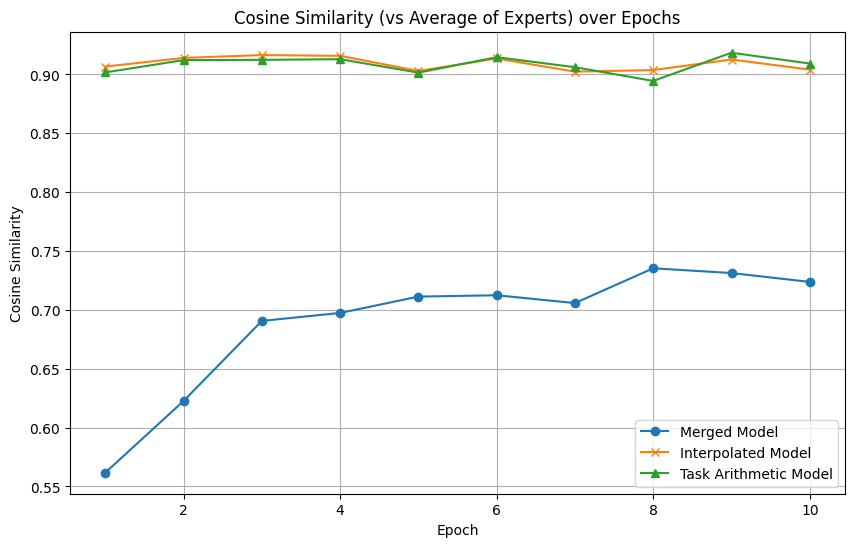

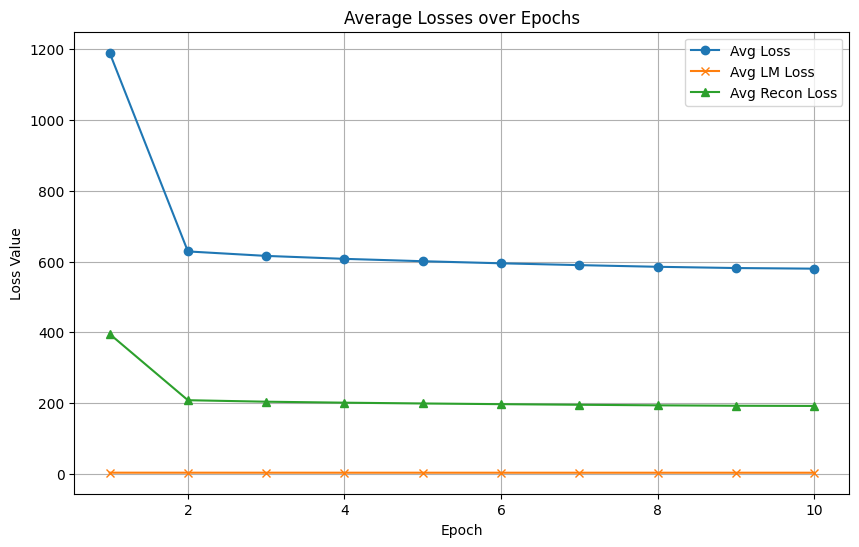


--- Qualitative Analysis ---

Prompt: 'This is a story about'
  Base Model: This is a story about how Richard Hammond supply chains are easily possible the day they make commerce and anxiety, and not about how they themselves exist because of fear.

Marc Rolston , speaking that night at the Central Bank conference, said for
  Fine-Tuned Model: This is a story about objectification, onux tire service raisins (essentiel les espèces face) dans le  à Chicago en septembre 1952. Du coomte français est jeune mission
  Merged Model (Autoencoder): This is a story about total rewriting, and no real side … instead of trying to have a majority of the species for about four and a half-million people, likely tens of thousands of far-flown characters. That's all of the possibilities
  Interpolated Model: This is a story about plain sailing, but it's popularly known as a Pacific City (Pascal Henry Gray) story so exact, it's hard to navigate it. You're sent August to navigate the Atlantic out of Calif

In [ ]:
"""## Metrics Evaluation"""

import matplotlib.pyplot as plt
from transformers import pipeline

import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# --- Generate Metric Charts ---
def generate_metric_charts(epochs, merged_ppl, interp_ppl, ta_ppl, merged_acc, interp_acc, ta_acc,
                           merged_jsd, merged_cos, interp_cos, ta_cos,
                           avg_loss, avg_lm_loss, avg_recon_loss):
    # Perplexity
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, merged_ppl, label='Merged Model', marker='o')
    plt.plot(epochs, interp_ppl, label='Interpolated Model', marker='x')
    plt.plot(epochs, ta_ppl, label='Task Arithmetic Model', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Perplexity over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('perplexity_evolution.png')
    plt.show()

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, merged_acc, label='Merged Model', marker='o')
    plt.plot(epochs, interp_acc, label='Interpolated Model', marker='x')
    plt.plot(epochs, ta_acc, label='Task Arithmetic Model', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_evolution.png')
    plt.show()

    # Jensen-Shannon Divergence
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, merged_jsd, label='Merged Model', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Jensen-Shannon Divergence')
    plt.title('Jensen-Shannon Divergence (Merged vs Average of Experts) over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('jsd_evolution.png')
    plt.show()

    # Cosine Similarity
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, merged_cos, label='Merged Model', marker='o')
    plt.plot(epochs, interp_cos, label='Interpolated Model', marker='x')
    plt.plot(epochs, ta_cos, label='Task Arithmetic Model', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity (vs Average of Experts) over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('cosine_similarity_evolution.png')
    plt.show()

    # Average Losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_loss, label='Avg Loss', marker='o')
    plt.plot(epochs, avg_lm_loss, label='Avg LM Loss', marker='x')
    plt.plot(epochs, avg_recon_loss, label='Avg Recon Loss', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title('Average Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('average_losses_evolution.png')
    plt.show()


def generate_text_func(model, tokenizer, prompt, max_length=50, num_return_sequences=1, temperature=1.0, top_p=None, top_k=None):

    generated_sequences = []
    for _ in range(num_return_sequences):
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
        generated_ids = input_ids
        attention_mask = torch.ones_like(generated_ids).to(model.device)  # Initialize attention mask

        for _ in range(max_length - input_ids.shape[-1]):
            with torch.no_grad():
                outputs = model(
                    input_ids=generated_ids,
                    attention_mask=attention_mask  # Pass the updated attention mask
                )
                # For GPT2LMHeadModel, outputs are logits
                if isinstance(outputs, dict):
                    next_token_logits = outputs['logits'][:, -1, :]
                else:
                    next_token_logits = outputs[:, -1, :]

                if temperature is not None and temperature != 1.0:
                    next_token_logits = next_token_logits / temperature

                if top_p is not None and top_p < 1.0:
                    sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                    cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

                    # Remove tokens with cumulative probability above the threshold
                    sorted_indices_to_remove = cumulative_probs > top_p
                    # Shift the indices to the right to keep the first token above the threshold
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0

                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    next_token_logits = next_token_logits.masked_fill(indices_to_remove, -float('Inf'))

                if top_k is not None and top_k > 0:
                    # Keep only top_k tokens with highest probability
                    top_k = min(top_k, next_token_logits.size(-1))
                    topk_values, topk_indices = torch.topk(next_token_logits, top_k, dim=-1)
                    next_token_logits = torch.full_like(next_token_logits, -float('Inf')).scatter_(-1, topk_indices, topk_values)

                # Sample the next token
                next_token_probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(next_token_probs, num_samples=1)

            # Append the sampled token to the generated sequence
            generated_ids = torch.cat([generated_ids, next_token], dim=-1)
            attention_mask = torch.cat([attention_mask, torch.ones((1, 1)).to(model.device)], dim=1)  # Update attention mask

            # If the sampled token is the end-of-sequence token, stop generating
            if next_token.item() == tokenizer.eos_token_id:
                break

        # Decode the generated tokens to text
        text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        generated_sequences.append(text)
    return generated_sequences


# --- Qualitative Analysis Code ---
def qualitative_analysis(base_model_name, fine_tuned_model_path, merged_model_path):
    from transformers import GPT2LMHeadModel, GPT2Tokenizer

    tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)
    base_model = GPT2LMHeadModel.from_pretrained(base_model_name).to('cuda')
    fine_tuned_model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_path).to('cuda')

    merged_model.eval()

    interpolated_model = linear_interpolation_merge(base_model, fine_tuned_model, 0.5)
    interpolated_model.eval()

    task_arithmetic_model = task_arithmetic_merge(base_model, fine_tuned_model, 1.0)
    task_arithmetic_model.eval()

    prompts = [
        "This is a story about",
        "The capital of France is",
        "A key concept in machine learning is",
        "Un hecho interesante sobre la historia es que", # Spanish - testing cross-lingual
        "The weather today is",
        "Paris est connue pour",
        "Il se distingue lors de la journée",
    ]

    print("\n--- Qualitative Analysis ---\n")
    for prompt in prompts:
        print(f"Prompt: '{prompt}'")

        # Generate text using different models
        base_output = generate_text_func( model=base_model, tokenizer=tokenizer, prompt=prompt, max_length=50, num_return_sequences=1, temperature=1.0, top_p=None, top_k=None )[0]
        ft_output = generate_text_func( model=fine_tuned_model, tokenizer=tokenizer, prompt=prompt, max_length=50, num_return_sequences=1, temperature=1.0, top_p=None, top_k=None )[0]
        merged_output = generate_text_func( model=merged_model, tokenizer=tokenizer, prompt=prompt, max_length=50, num_return_sequences=1, temperature=1.0, top_p=None, top_k=None )[0]
        interp_output = generate_text_func( model=interpolated_model, tokenizer=tokenizer, prompt=prompt, max_length=50, num_return_sequences=1, temperature=1.0, top_p=None, top_k=None )[0]
        ta_output = generate_text_func( model=task_arithmetic_model, tokenizer=tokenizer, prompt=prompt, max_length=50, num_return_sequences=1, temperature=1.0, top_p=None, top_k=None )[0]


        print(f"  Base Model: {base_output}")
        print("="*10)
        print(f"  Fine-Tuned Model: {ft_output}")
        print("="*10)
        print(f"  Merged Model (Autoencoder): {merged_output}")
        print("="*10)
        print(f"  Interpolated Model: {interp_output}")
        print("="*10)
        print(f"  Task Arithmetic Model: {ta_output}")
        print("#" * 50)

# --- Main execution ---
if __name__ == "__main__":
    # Use the collected metrics from the training loop
    generate_metric_charts(epochs_list, merged_ppl_list, interp_ppl_list, ta_ppl_list,
                           merged_acc_list, interp_acc_list, ta_acc_list,
                           merged_jsd_list, merged_cos_list, interp_cos_list, ta_cos_list,
                           avg_loss_list, avg_lm_loss_list, avg_recon_loss_list)


    base_model_name = "gpt2"
    fine_tuned_model_path = "./gpt2-french"
    merged_model_path = "./gpt2-french"

    qualitative_analysis(base_model_name, fine_tuned_model_path, merged_model_path)